## **Project Topic:  Store Item Demand Forecasting**

### **Description**


**This file is provided as a way to explore different time series techniques on a relatively simple and clean dataset.**

**We are given 5 years of store-item sales data, and asked to predict 3 months of sales for 50 different items at 10 different stores.**

 **What's the best way to deal with seasonality? Should stores be modeled separately, or can you pool them together?**

**Variables:**


* date
* store
* item
* sales


### **What is Time Series Analysis?**

Time series analysis is a specific way of analyzing a sequence of data collected.

What sets time series data apart from other data is that the analysis can show how variables change over time. So that means time is a crucial variable because it shows how the data adjusts over the course of the data. It provides an additional source of information and a set order of dependencies between the data.

### **What is Machine Learning from Time Series?**

Machine learning methods offer a lot of promise for time series forecasting, such as the automatic learning of temporal dependence and the automatic handling of temporal structures like level, trends and seasonality.

This notebook uses Microsoft's LightGBM and SMAPE - Symmetric mean absolute percentage error (adjusted MAPE) as metric to custom cost function.

## **Dataset story**

There are two datasets:**demand_forecasting_train** and **demand_forecasting_test**

Columns of demand_forecasting_train dataset: date, store, item, sales

Columns of demand_forecasting_train dataset: id, date, store, item

So as you can see the train part doesn't consist id's (as there's no need for that column) and test part doesn't consist sales (as they will be predicted).

**What is about the dataset?**

This dataset includes 5 year sale datas of 50 different items of 10 different stores of a company.

**What is our task? What can be done?**

There is a lot of things we can do with that data, but this notebook will be predicting 3 months of sales looking only in the item basis, only in the store basis and also looking together in the specified item-store basis.

**The goal of this notebook is to develop and compare different approaches to time-series problems.**

**Content:**

Time series visualization with ploty.

How to transform a time series dataset into a supervised learning problem.

How to develop a Multilayer Perceptron model for a univariate time series forecasting problem.

How to develop a Convolutional Neural Network model for a univariate time series forecasting problem.

How to develop a Long Short-Term Memory network model for a univariate time series forecasting problem.

How to develop a Hybrid CNN-LSTM model for a univariate time series forecasting problem.


In [ ]:
!pip install plotly==3.10.0
from chart_studio import plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41.5 MB 1.5 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11448 sha256=02a1eb266c02b4a12956d34621946c23c6a2f1c40e45464f8782a9aae8f69f02
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying
  Attempting uninstall: plotly
    Found existing installation: plotly 5.5.0
    Uninstalling plotly-5.5.0:
      Successfully uninstalled plotly-5.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cufflinks 0.17.3 requires plotly>=4.1.1, but you have plotly 3.10.0 which is incompatible.


In [ ]:
#Install Pandas Data Reader 
!pip install pandas-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#import libraies
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
import tensorflow
tensorflow.random.set_seed(1)
from numpy.random import seed
tensorflow.random.set_seed(1)
seed(1)

### **Loading dataset**

In [ ]:
train = pd.read_csv('/content/train.csv', parse_dates=['date'])
test = pd.read_csv('/content/test.csv', parse_dates=['date'])

### **Train test**

In [ ]:
train.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [ ]:
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [ ]:
train.shape

(913000, 4)

In [ ]:
train.nunique()

date     1826
store      10
item       50
sales     213
dtype: int64

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


### **Time period of the train dataset**

In [ ]:
print('Min date from train set: %s' % train['date'].min().date())
print('Max date from train set: %s' % train['date'].max().date())

Min date from train set: 2013-01-01
Max date from train set: 2017-12-31


### **Let's find out what's the time gap between the last day from training set from the last day of the test set, this will be out lag (the amount of day that need to be forecast)**

In [ ]:
lag_size = (test['date'].max().date() - train['date'].max().date()).days
print('Max date from train set: %s' % train['date'].max().date())
print('Max date from test set: %s' % test['date'].max().date())
print('Forecast lag size', lag_size)

Max date from train set: 2017-12-31
Max date from test set: 2018-03-31
Forecast lag size 90


## **Basic EDA**

In [ ]:
# How many stores and items are there?
train.store.nunique(), test.store.nunique(), train.item.nunique(), test.item.nunique()

(10, 10, 50, 50)

In [ ]:
train.groupby(['store'])['item'].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

**Total number of sales in each store:**

In [ ]:
#Sales Data Per Store

def total_sales_per_store(train):
    sales_by_store = train.groupby('store')['sales'].sum().reset_index()
    
    fig, ax = plt.subplots(figsize=(10,6))
    sns.barplot(sales_by_store.store, sales_by_store.sales, order=sales_by_store.sort_values('sales',ascending = False).store)
          
    ax.set(xlabel = "Store Id", ylabel = "Sum of Sales", title = "Total Sales Per Store")
    plt.xticks(fontsize=12, rotation=45)
       
    return sales_by_store

,store,sales
0,1,4315603
1,2,6120128
2,3,5435144
3,4,5012639
4,5,3631016
5,6,3627670
6,7,3320009
7,8,5856169
8,9,5025976
9,10,5360158


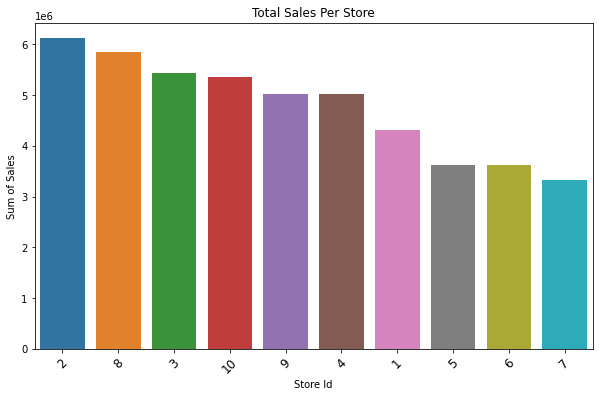

In [ ]:
total_sales_per_store(train)

In [ ]:
#Sales Data Per Item

def total_sales_per_item(train):
    sales_by_store = train.groupby('item')['sales'].sum().reset_index()
    
    fig, ax = plt.subplots(figsize=(20,8))
    sns.barplot(sales_by_store.item, sales_by_store.sales, order=sales_by_store.sort_values('sales', ascending = False).item)
    
    ax.set(xlabel = "Item Id", ylabel = "Sum of Sales", title = "Total Sales Per Item")
    plt.xticks(fontsize=12, rotation=90)
    
    return

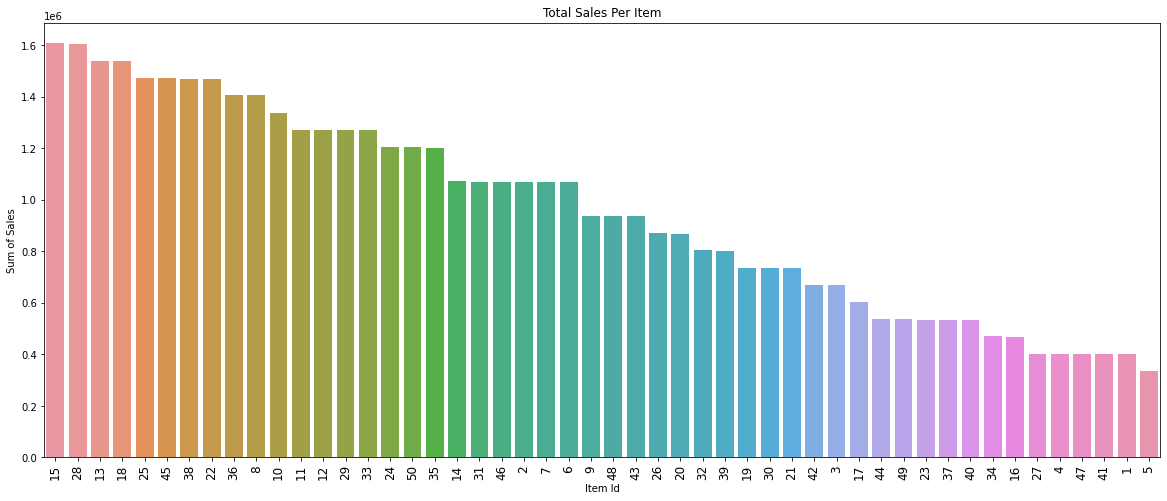

In [ ]:
total_sales_per_item(train)

### **But, which PERIOD OF TIME (day, week, month...) was the most profitable (considering all product and item sales)?**

In [ ]:
def period_profitable(period="D", plot=False):

    train_perio = train.copy()
    train_perio.set_index("date", inplace=True)
    train_perio = train_perio.resample(period, closed='left').sum()
    train_perio.drop(columns=["store", "item"], inplace=True)
    train_perio["growth_rate"] = train_perio["sales"].pct_change() * 100
    train_perio.loc[[train_perio.index.min(), train_perio.index.max()], 'growth_rate'] = 0
    print(train_perio["sales"][train_perio["sales"] == train_perio["sales"].max()])

    if plot:
        train_perio["growth_rate"].plot(color="k", figsize=(12,4))
        plt.title(f"{period}'s growth rate")
        plt.xlabel("Date")
        plt.ylabel("Growth Rate %")
        plt.show()

### **Most profitable DAY of dataset:**

In [ ]:
train_day = period_profitable("D")

date
2017-07-02    44936
Freq: D, Name: sales, dtype: int64


### **Most profitable QUARTER of dataset:**

In [ ]:
train_quarter = period_profitable("Q")

date
2017-09-30    3135618
Freq: Q-DEC, Name: sales, dtype: int64


### **Let's find which week was the most profitable and how actually weekly growth rates compare to previous week sales performance:**

date
2017-07-23    264008
Freq: W-SUN, Name: sales, dtype: int64


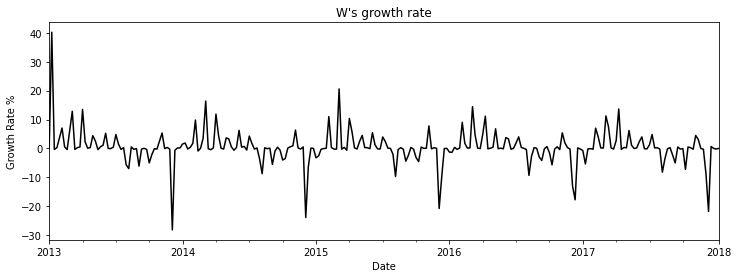

In [ ]:
train_week = period_profitable("W", True)

### **So as we can see, weekly growth rates compared to previous week sales performance are losing the volatility. This implicit in the stabilization of our company sales, predictability of future sales and financial trust.**

In [ ]:
df = pd.concat([train, test], sort=False)

In [ ]:
# How many items are in the store?
df.groupby(["store"])["item"].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [ ]:
# Summary Stats for each store
df.groupby(["store"]).agg({"sales": ["count","sum", "mean", "median", "std", "min", "max"]})

sales                                                    
       count        sum       mean median        std  min    max
store                                                           
1      91300  4315603.0  47.268379   44.0  24.006252  1.0  155.0
2      91300  6120128.0  67.033165   62.0  33.595810  3.0  231.0
3      91300  5435144.0  59.530602   55.0  29.974102  3.0  196.0
4      91300  5012639.0  54.902946   51.0  27.733097  4.0  186.0
5      91300  3631016.0  39.770164   37.0  20.365757  2.0  130.0
6      91300  3627670.0  39.733516   37.0  20.310451  0.0  134.0
7      91300  3320009.0  36.363735   34.0  18.684825  1.0  122.0
8      91300  5856169.0  64.142048   60.0  32.231751  4.0  204.0
9      91300  5025976.0  55.049025   51.0  27.832186  4.0  195.0
10     91300  5360158.0  58.709288   54.0  29.554994  3.0  187.0

In [ ]:
# Summary Stats for each item
df.groupby(["item"]).agg({"sales": ["count","sum", "mean", "median", "std", "min", "max"]})

sales                                                     
      count        sum       mean median        std   min    max
item                                                            
1     18260   401384.0  21.981599   21.0   8.468922   1.0   59.0
2     18260  1069564.0  58.574151   56.0  20.093015   9.0  150.0
3     18260   669087.0  36.642223   35.0  13.179441   7.0  104.0
4     18260   401907.0  22.010241   21.0   8.403898   0.0   66.0
5     18260   335230.0  18.358708   18.0   7.265167   1.0   50.0
6     18260  1068281.0  58.503888   56.0  20.174898  11.0  148.0
7     18260  1068777.0  58.531051   56.0  20.146002  11.0  141.0
8     18260  1405108.0  76.950055   74.0  26.130697  15.0  181.0
9     18260   938379.0  51.389869   49.5  17.790158   6.0  134.0
10    18260  1337133.0  73.227437   70.0  24.823725  14.0  175.0
11    18260  1271925.0  69.656353   67.0  23.744732  11.0  170.0
12    18260  1271534.0  69.634940   67.0  23.738663  12.0  170.0
13    18260  1539621.0  84.316594   81.0  28.311031  20.0  210.0
14    18260  1071531.0  58.681873   56.0  20.079860  12.0  152.0
15    18260  1607442.0  88.030778   85.0  29.522852  17.0  231.0
16    18260   468480.0  25.656079   25.0   9.603270   2.0   70.0
17    18260   602486.0  32.994852   32.0  11.967610   4.0   83.0
18    18260  1538876.0  84.275794   81.0  28.430621  18.0  208.0
19    18260   736892.0  40.355531   39.0  14.332645   5.0   99.0
20    18260   867641.0  47.515936   46.0  16.490487   9.0  127.0
21    18260   736190.0  40.317087   39.0  14.338006   7.0  109.0
22    18260  1469971.0  80.502245   78.0  27.118163  14.0  214.0
23    18260   534979.0  29.297864   28.0  10.819549   3.0   81.0
24    18260  1205975.0  66.044633   64.0  22.531555  14.0  156.0
25    18260  1473334.0  80.686418   78.0  27.238817  18.0  193.0
26    18260   869981.0  47.644085   46.0  16.723912   8.0  119.0
27    18260   402628.0  22.049726   21.0   8.461641   1.0   59.0
28    18260  1604713.0  87.881325   85.0  29.501781  16.0  206.0
29    18260  1271240.0  69.618839   67.0  23.635631  15.0  173.0
30    18260   736554.0  40.337021   39.0  14.363331   5.0  115.0
31    18260  1070845.0  58.644304   57.0  20.104705  10.0  159.0
32    18260   803107.0  43.981763   42.0  15.574556   5.0  119.0
33    18260  1270183.0  69.560953   67.0  23.718343  15.0  169.0
34    18260   469935.0  25.735761   25.0   9.617910   2.0   79.0
35    18260  1201541.0  65.801807   63.0  22.461990  12.0  168.0
36    18260  1406548.0  77.028916   74.0  26.067440  16.0  188.0
37    18260   534258.0  29.258379   28.0  10.771547   3.0   74.0
38    18260  1470330.0  80.521906   77.0  27.141799  15.0  188.0
39    18260   801311.0  43.883406   42.0  15.511550   7.0  112.0
40    18260   534094.0  29.249398   28.0  10.822959   3.0   74.0
41    18260   401759.0  22.002136   21.0   8.402470   2.0   60.0
42    18260   669925.0  36.688116   35.0  13.215112   5.0   96.0
43    18260   936635.0  51.294359   49.0  17.801008   9.0  126.0
44    18260   536811.0  29.398193   28.0  10.797738   3.0   78.0
45    18260  1471467.0  80.584173   78.0  27.318402  18.0  205.0
46    18260  1070764.0  58.639869   56.0  20.220879  11.0  150.0
47    18260   401781.0  22.003341   21.0   8.420102   2.0   61.0
48    18260   937703.0  51.352848   49.0  17.881917   8.0  130.0
49    18260   535663.0  29.335323   28.0  10.874788   3.0   77.0
50    18260  1203009.0  65.882202   63.0  22.416031  12.0  164.0

In [ ]:
# Summary Stats for each item
df.groupby(["item"]).agg({"sales": ["count","sum", "mean", "median", "std", "min", "max"]})

sales                                                     
      count        sum       mean median        std   min    max
item                                                            
1     18260   401384.0  21.981599   21.0   8.468922   1.0   59.0
2     18260  1069564.0  58.574151   56.0  20.093015   9.0  150.0
3     18260   669087.0  36.642223   35.0  13.179441   7.0  104.0
4     18260   401907.0  22.010241   21.0   8.403898   0.0   66.0
5     18260   335230.0  18.358708   18.0   7.265167   1.0   50.0
6     18260  1068281.0  58.503888   56.0  20.174898  11.0  148.0
7     18260  1068777.0  58.531051   56.0  20.146002  11.0  141.0
8     18260  1405108.0  76.950055   74.0  26.130697  15.0  181.0
9     18260   938379.0  51.389869   49.5  17.790158   6.0  134.0
10    18260  1337133.0  73.227437   70.0  24.823725  14.0  175.0
11    18260  1271925.0  69.656353   67.0  23.744732  11.0  170.0
12    18260  1271534.0  69.634940   67.0  23.738663  12.0  170.0
13    18260  1539621.0  84.316594   81.0  28.311031  20.0  210.0
14    18260  1071531.0  58.681873   56.0  20.079860  12.0  152.0
15    18260  1607442.0  88.030778   85.0  29.522852  17.0  231.0
16    18260   468480.0  25.656079   25.0   9.603270   2.0   70.0
17    18260   602486.0  32.994852   32.0  11.967610   4.0   83.0
18    18260  1538876.0  84.275794   81.0  28.430621  18.0  208.0
19    18260   736892.0  40.355531   39.0  14.332645   5.0   99.0
20    18260   867641.0  47.515936   46.0  16.490487   9.0  127.0
21    18260   736190.0  40.317087   39.0  14.338006   7.0  109.0
22    18260  1469971.0  80.502245   78.0  27.118163  14.0  214.0
23    18260   534979.0  29.297864   28.0  10.819549   3.0   81.0
24    18260  1205975.0  66.044633   64.0  22.531555  14.0  156.0
25    18260  1473334.0  80.686418   78.0  27.238817  18.0  193.0
26    18260   869981.0  47.644085   46.0  16.723912   8.0  119.0
27    18260   402628.0  22.049726   21.0   8.461641   1.0   59.0
28    18260  1604713.0  87.881325   85.0  29.501781  16.0  206.0
29    18260  1271240.0  69.618839   67.0  23.635631  15.0  173.0
30    18260   736554.0  40.337021   39.0  14.363331   5.0  115.0
31    18260  1070845.0  58.644304   57.0  20.104705  10.0  159.0
32    18260   803107.0  43.981763   42.0  15.574556   5.0  119.0
33    18260  1270183.0  69.560953   67.0  23.718343  15.0  169.0
34    18260   469935.0  25.735761   25.0   9.617910   2.0   79.0
35    18260  1201541.0  65.801807   63.0  22.461990  12.0  168.0
36    18260  1406548.0  77.028916   74.0  26.067440  16.0  188.0
37    18260   534258.0  29.258379   28.0  10.771547   3.0   74.0
38    18260  1470330.0  80.521906   77.0  27.141799  15.0  188.0
39    18260   801311.0  43.883406   42.0  15.511550   7.0  112.0
40    18260   534094.0  29.249398   28.0  10.822959   3.0   74.0
41    18260   401759.0  22.002136   21.0   8.402470   2.0   60.0
42    18260   669925.0  36.688116   35.0  13.215112   5.0   96.0
43    18260   936635.0  51.294359   49.0  17.801008   9.0  126.0
44    18260   536811.0  29.398193   28.0  10.797738   3.0   78.0
45    18260  1471467.0  80.584173   78.0  27.318402  18.0  205.0
46    18260  1070764.0  58.639869   56.0  20.220879  11.0  150.0
47    18260   401781.0  22.003341   21.0   8.420102   2.0   61.0
48    18260   937703.0  51.352848   49.0  17.881917   8.0  130.0
49    18260   535663.0  29.335323   28.0  10.874788   3.0   77.0
50    18260  1203009.0  65.882202   63.0  22.416031  12.0  164.0

## **Histogram: Store Sales**

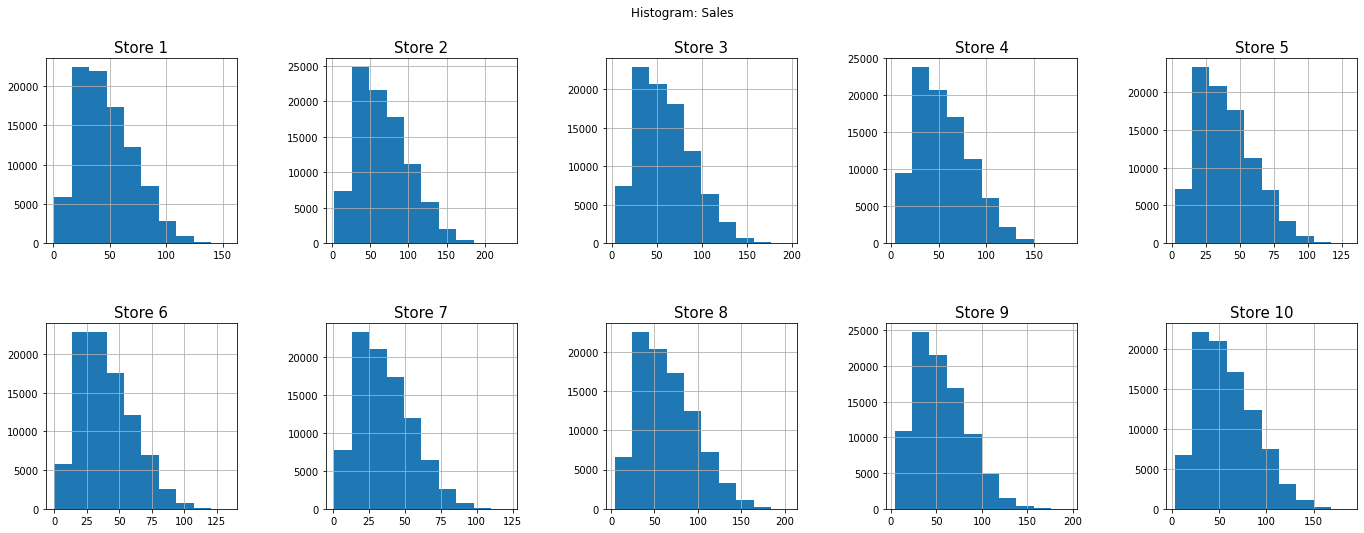

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for i in range(1,11):
    if i < 6:
        train[train.store == i].sales.hist(ax=axes[0, i-1])
        axes[0,i-1].set_title("Store " + str(i), fontsize = 15)
        
    else:
        train[train.store == i].sales.hist(ax=axes[1, i - 6])
        axes[1,i-6].set_title("Store " + str(i), fontsize = 15)
plt.tight_layout(pad=4.5)
plt.suptitle("Histogram: Sales");

## **Sales distribution for each item in the 1st store**

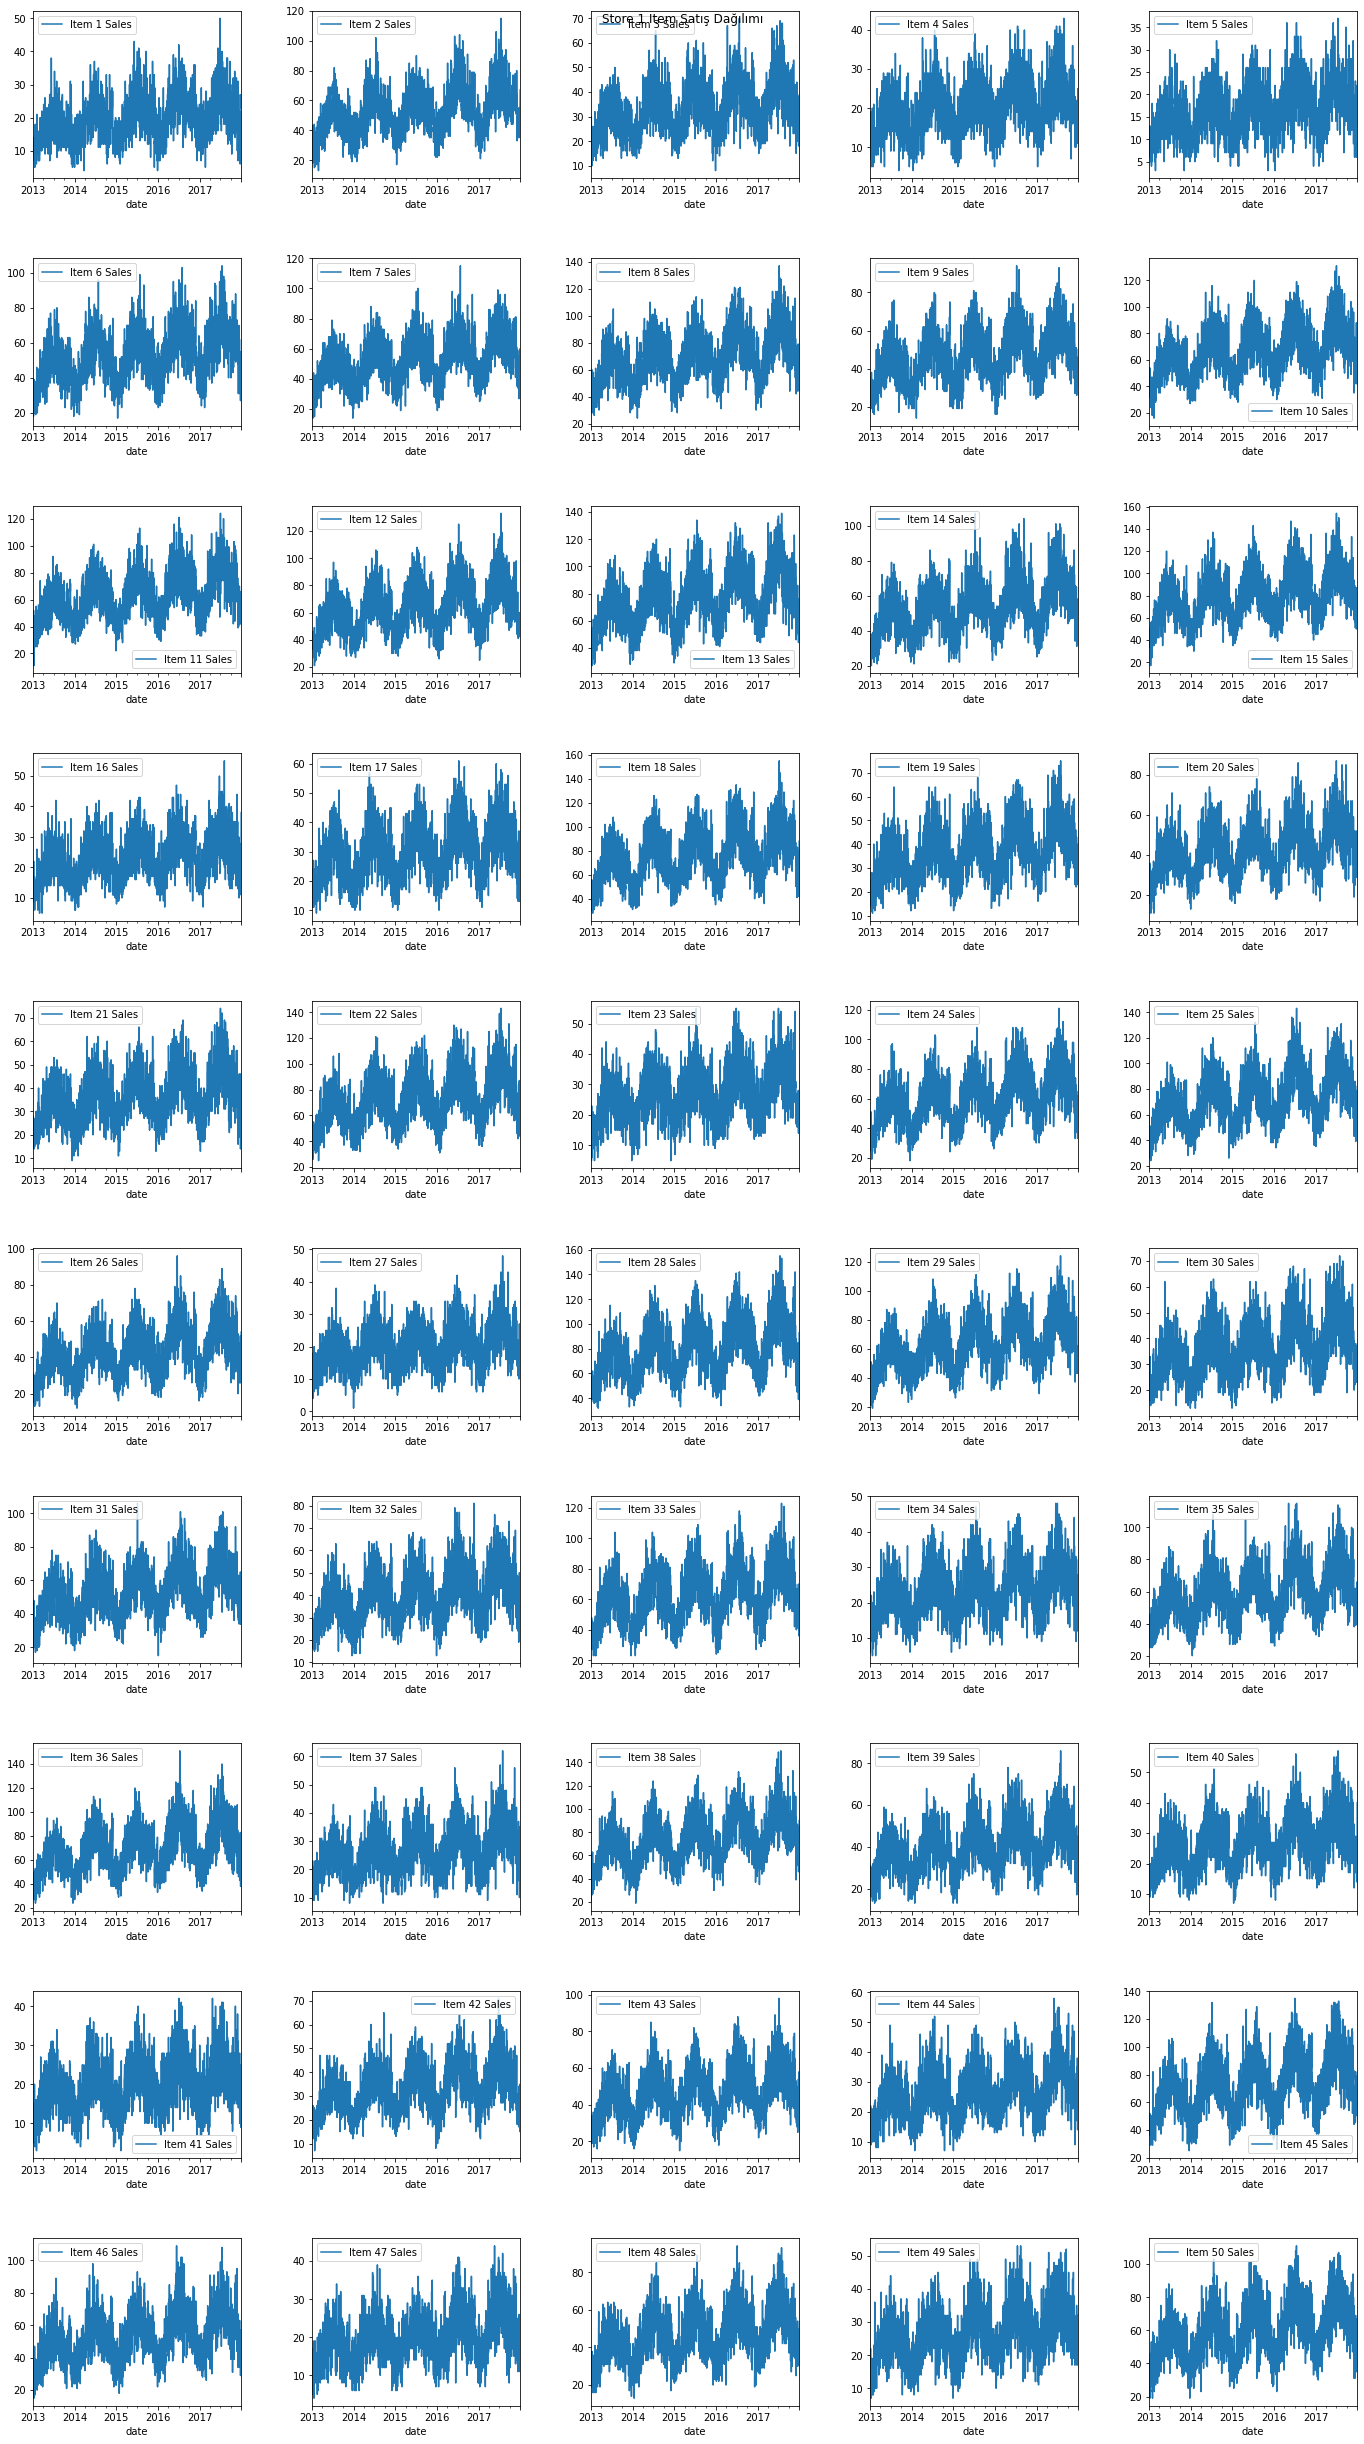

In [ ]:
store = 1
sub = train[train.store == store].set_index("date")

fig, axes = plt.subplots(10, 5, figsize=(20, 35))
for i in range(1,51):
    if i < 6:
        sub[sub.item == i].sales.plot(ax=axes[0, i-1], legend=True, label = "Item "+str(i)+" Sales")
    if i >= 6 and i<11:
        sub[sub.item == i].sales.plot(ax=axes[1, i - 6], legend=True, label = "Item "+str(i)+" Sales")
    if i >= 11 and i<16:
        sub[sub.item == i].sales.plot(ax=axes[2, i - 11], legend=True, label = "Item "+str(i)+" Sales")    
    if i >= 16 and i<21:
        sub[sub.item == i].sales.plot(ax=axes[3, i - 16], legend=True, label = "Item "+str(i)+" Sales")    
    if i >= 21 and i<26:
        sub[sub.item == i].sales.plot(ax=axes[4, i - 21], legend=True, label = "Item "+str(i)+" Sales")  
    if i >= 26 and i<31:
        sub[sub.item == i].sales.plot(ax=axes[5, i - 26], legend=True, label = "Item "+str(i)+" Sales")    
    if i >= 31 and i<36:
        sub[sub.item == i].sales.plot(ax=axes[6, i - 31], legend=True, label = "Item "+str(i)+" Sales")    
    if i >= 36 and i<41:
        sub[sub.item == i].sales.plot(ax=axes[7, i - 36], legend=True, label = "Item "+str(i)+" Sales")    
    if i >= 41 and i<46:
        sub[sub.item == i].sales.plot(ax=axes[8, i - 41], legend=True, label = "Item "+str(i)+" Sales") 
    if i >= 46 and i<51:
        sub[sub.item == i].sales.plot(ax=axes[9, i - 46], legend=True, label = "Item "+str(i)+" Sales") 
plt.tight_layout(pad=4.5)
plt.suptitle("Store 1 Item Satış Dağılımı");

## **Correlation between total sales of stores**

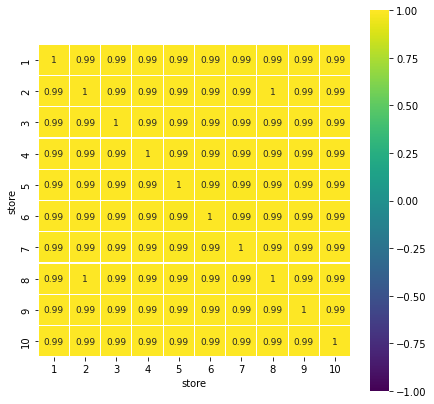

In [ ]:
storesales = train.groupby(["date", "store"]).sales.sum().reset_index().set_index("date")
corr =  pd.pivot_table(storesales, values = "sales", columns="store", index="date").corr(method = "spearman")
plt.figure(figsize = (7,7))
sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.5)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 9}, square=True);

In [ ]:
# To explore the time series data first we need to aggregate the sales by day
daily_sales = train.groupby('date', as_index=False)['sales'].sum()
store_daily_sales = train.groupby(['store', 'date'], as_index=False)['sales'].sum()
item_daily_sales = train.groupby(['item', 'date'], as_index=False)['sales'].sum()

### **Sub-sample train set to get only the last year of data and reduce training time**

In [ ]:
train = train[(train['date'] >= '2017-01-01')]

### **Rearrange dataset so we can apply shift methods**

In [ ]:
train_gp = train.sort_values('date').groupby(['item', 'store', 'date'], as_index=False)
train_gp = train_gp.agg({'sales':['mean']})
train_gp.columns = ['item', 'store', 'date', 'sales']
train_gp.head()

,item,store,date,sales
0,1,1,2017-01-01,19.0
1,1,1,2017-01-02,15.0
2,1,1,2017-01-03,10.0
3,1,1,2017-01-04,16.0
4,1,1,2017-01-05,14.0


### **Transform the data into a time series problem**

In [ ]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### **We will use the current timestep and the last 29 to forecast 90 days ahead**

In [ ]:
window = 29
lag = lag_size
series = series_to_supervised(train_gp.drop('date', axis=1), window=window, lag=lag)
series.head()

,item(t-29),store(t-29),sales(t-29),item(t-28),store(t-28),sales(t-28),item(t-27),store(t-27),sales(t-27),item(t-26),...,sales(t-2),item(t-1),store(t-1),sales(t-1),item(t),store(t),sales(t),item(t+90),store(t+90),sales(t+90)
29,1.0,1.0,19.0,1.0,1.0,15.0,1.0,1.0,10.0,1.0,...,16.0,1.0,1.0,24.0,1,1,9.0,1.0,1.0,33.0
30,1.0,1.0,15.0,1.0,1.0,10.0,1.0,1.0,16.0,1.0,...,24.0,1.0,1.0,9.0,1,1,17.0,1.0,1.0,15.0
31,1.0,1.0,10.0,1.0,1.0,16.0,1.0,1.0,14.0,1.0,...,9.0,1.0,1.0,17.0,1,1,15.0,1.0,1.0,21.0
32,1.0,1.0,16.0,1.0,1.0,14.0,1.0,1.0,24.0,1.0,...,17.0,1.0,1.0,15.0,1,1,17.0,1.0,1.0,29.0
33,1.0,1.0,14.0,1.0,1.0,24.0,1.0,1.0,14.0,1.0,...,15.0,1.0,1.0,17.0,1,1,24.0,1.0,1.0,19.0


### **Drop rows with different item or store values than the shifted columns**

In [ ]:
last_item = 'item(t-%d)' % window
last_store = 'store(t-%d)' % window
series = series[(series['store(t)'] == series[last_store])]
series = series[(series['item(t)'] == series[last_item])]

### **Remove unwanted columns**

In [ ]:
columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['item', 'store']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['item', 'store']]
series.drop(columns_to_drop, axis=1, inplace=True)
series.drop(['item(t)', 'store(t)'], axis=1, inplace=True)

# **Train/validation split**

In [ ]:
# Label
labels_col = 'sales(t+%d)' % lag_size
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.4, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (100746, 30)
Validation set shape (67164, 30)


,sales(t-29),sales(t-28),sales(t-27),sales(t-26),sales(t-25),sales(t-24),sales(t-23),sales(t-22),sales(t-21),sales(t-20),...,sales(t-9),sales(t-8),sales(t-7),sales(t-6),sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t-1),sales(t)
18801,97.0,111.0,90.0,115.0,123.0,70.0,99.0,74.0,107.0,108.0,...,85.0,95.0,123.0,109.0,127.0,132.0,87.0,101.0,102.0,114.0
160385,38.0,43.0,43.0,55.0,47.0,51.0,38.0,41.0,37.0,59.0,...,41.0,38.0,38.0,53.0,53.0,45.0,44.0,24.0,30.0,37.0
73123,55.0,45.0,41.0,46.0,47.0,36.0,30.0,46.0,41.0,42.0,...,38.0,36.0,40.0,50.0,44.0,44.0,40.0,38.0,50.0,49.0
90428,139.0,157.0,85.0,99.0,136.0,110.0,121.0,123.0,147.0,91.0,...,130.0,128.0,128.0,95.0,116.0,110.0,117.0,118.0,129.0,132.0
167151,86.0,58.0,88.0,87.0,114.0,113.0,64.0,76.0,87.0,81.0,...,55.0,66.0,59.0,53.0,63.0,59.0,77.0,39.0,56.0,62.0


## **MLP for Time Series Forecasting**

* First we will use a Multilayer Perceptron model or MLP model, here our model will have input features equal to the window size.
* The thing with MLP models is that the model don't take the input as sequenced data, so for the model, it is just receiving inputs and don't treat them as sequenced data, that may be a problem since the model won't see the data with the sequence patter that it has.
* Input shape [samples, timesteps].

In [ ]:
epochs = 40
batch = 256
lr = 0.0003
adam = optimizers.Adam(lr)

In [ ]:
model_mlp = Sequential()
model_mlp.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mse', optimizer=adam)
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               3100      
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 3,201
Trainable params: 3,201
Non-trainable params: 0
_________________________________________________________________


In [ ]:
mlp_history = model_mlp.fit(X_train.values, Y_train, validation_data=(X_valid.values, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
3149/3149 - 7s - loss: 396.4911 - val_loss: 371.0771 - 7s/epoch - 2ms/step
Epoch 2/40
3149/3149 - 7s - loss: 363.6005 - val_loss: 362.2590 - 7s/epoch - 2ms/step
Epoch 3/40
3149/3149 - 6s - loss: 357.9644 - val_loss: 373.4828 - 6s/epoch - 2ms/step
Epoch 4/40
3149/3149 - 9s - loss: 356.4312 - val_loss: 380.6350 - 9s/epoch - 3ms/step
Epoch 5/40
3149/3149 - 7s - loss: 355.3289 - val_loss: 355.3835 - 7s/epoch - 2ms/step
Epoch 6/40
3149/3149 - 7s - loss: 353.8871 - val_loss: 351.7739 - 7s/epoch - 2ms/step
Epoch 7/40
3149/3149 - 7s - loss: 352.6126 - val_loss: 356.7795 - 7s/epoch - 2ms/step
Epoch 8/40
3149/3149 - 7s - loss: 351.6898 - val_loss: 349.6088 - 7s/epoch - 2ms/step
Epoch 9/40
3149/3149 - 7s - loss: 351.1114 - val_loss: 353.5353 - 7s/epoch - 2ms/step
Epoch 10/40
3149/3149 - 7s - loss: 349.6491 - val_loss: 349.3540 - 7s/epoch - 2ms/step
Epoch 11/40
3149/3149 - 7s - loss: 348.8848 - val_loss: 347.3269 - 7s/epoch - 2ms/step
Epoch 12/40
3149/3149 - 7s - loss: 347.2905 - val_lo

### **CNN for Time Series Forecasting**
* For the CNN model we will use one convolutional hidden layer followed by a max pooling layer. The filter maps are then flattened before being interpreted by a Dense layer and outputting a prediction.
* The convolutional layer should be able to identify patterns between the timesteps.
* Input shape [samples, timesteps, features].

### **Data preprocess**
* Reshape from [samples, timesteps] into [samples, timesteps, features].
* This same reshaped data will be used on the CNN and the LSTM model.

In [ ]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (100746, 30, 1)
Validation set shape (67164, 30, 1)


In [ ]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=adam)
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 29, 64)            192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 14, 64)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 896)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                44850     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 45,093
Trainable params: 45,093
Non-trainable params: 0
__________________________________________________

In [ ]:
cnn_history = model_cnn.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
3149/3149 - 15s - loss: 415.7126 - val_loss: 387.4025 - 15s/epoch - 5ms/step
Epoch 2/40
3149/3149 - 14s - loss: 384.4167 - val_loss: 380.9254 - 14s/epoch - 5ms/step
Epoch 3/40
3149/3149 - 14s - loss: 373.1086 - val_loss: 372.8943 - 14s/epoch - 5ms/step
Epoch 4/40
3149/3149 - 14s - loss: 368.4986 - val_loss: 382.8452 - 14s/epoch - 5ms/step
Epoch 5/40
3149/3149 - 14s - loss: 366.7286 - val_loss: 365.5786 - 14s/epoch - 4ms/step
Epoch 6/40
3149/3149 - 14s - loss: 364.7249 - val_loss: 361.7636 - 14s/epoch - 4ms/step
Epoch 7/40
3149/3149 - 14s - loss: 362.9218 - val_loss: 369.1317 - 14s/epoch - 5ms/step
Epoch 8/40
3149/3149 - 12s - loss: 361.5766 - val_loss: 356.6208 - 12s/epoch - 4ms/step
Epoch 9/40
3149/3149 - 14s - loss: 360.3258 - val_loss: 364.4939 - 14s/epoch - 5ms/step
Epoch 10/40
3149/3149 - 14s - loss: 358.5699 - val_loss: 355.0561 - 14s/epoch - 4ms/step
Epoch 11/40
3149/3149 - 14s - loss: 357.1760 - val_loss: 353.7932 - 14s/epoch - 4ms/step
Epoch 12/40
3149/3149 - 12s - 

## **LSTM for Time Series Forecasting**
* Now the LSTM model actually sees the input data as a sequence, so it's able to learn patterns from sequenced data (assuming it exists) better than the other ones, especially patterns from long sequences.
* Input shape [samples, timesteps, features].

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=adam)
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
3149/3149 - 48s - loss: 517.8193 - val_loss: 459.7083 - 48s/epoch - 15ms/step
Epoch 2/40
3149/3149 - 47s - loss: 415.2658 - val_loss: 389.3236 - 47s/epoch - 15ms/step
Epoch 3/40
3149/3149 - 47s - loss: 387.4067 - val_loss: 387.7439 - 47s/epoch - 15ms/step
Epoch 4/40
3149/3149 - 47s - loss: 377.1862 - val_loss: 376.2082 - 47s/epoch - 15ms/step
Epoch 5/40
3149/3149 - 47s - loss: 365.4997 - val_loss: 353.9078 - 47s/epoch - 15ms/step
Epoch 6/40
3149/3149 - 48s - loss: 355.7324 - val_loss: 355.6357 - 48s/epoch - 15ms/step
Epoch 7/40
3149/3149 - 47s - loss: 350.2036 - val_loss: 354.4212 - 47s/epoch - 15ms/step
Epoch 8/40
3149/3149 - 48s - loss: 346.0910 - val_loss: 342.4826 - 48s/epoch - 15ms/step
Epoch 9/40
3149/3149 - 48s - loss: 347.1963 - val_loss: 348.6291 - 48s/epoch - 15ms/step
Epoch 10/40
3149/3149 - 47s - loss: 342.9343 - val_loss: 352.4878 - 47s/epoch - 15ms/step
Epoch 11/40
3149/3149 - 48s - loss: 341.2950 - val_loss: 346.1524 - 48s/epoch - 15ms/step
Epoch 12/40
3149/31

## **CNN-LSTM for Time Series Forecasting**
* Input shape [samples, subsequences, timesteps, features].

### **Model explanation**
"The benefit of this model is that the model can support very long input sequences that can be read as blocks or subsequences by the CNN model, then pieced together by the LSTM model."

"When using a hybrid CNN-LSTM model, we will further divide each sample into further subsequences. The CNN model will interpret each sub-sequence and the LSTM will piece together the interpretations from the subsequences. As such, we will split each sample into 2 subsequences of 2 times per subsequence."

"The CNN will be defined to expect 2 timesteps per subsequence with one feature. The entire CNN model is then wrapped in TimeDistributed wrapper layers so that it can be applied to each subsequence in the sample. The results are then interpreted by the LSTM layer before the model outputs a prediction."

## **Data preprocess**
* Reshape from [samples, timesteps, features] into [samples, subsequences, timesteps, features].

In [ ]:
subsequences = 2
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (100746, 2, 15, 1)
Validation set shape (67164, 2, 15, 1)


In [ ]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer=adam)

In [ ]:
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
3149/3149 - 24s - loss: 435.2946 - val_loss: 422.6710 - 24s/epoch - 7ms/step
Epoch 2/40
3149/3149 - 23s - loss: 410.3062 - val_loss: 389.8915 - 23s/epoch - 7ms/step
Epoch 3/40
3149/3149 - 22s - loss: 397.0901 - val_loss: 403.9695 - 22s/epoch - 7ms/step
Epoch 4/40
3149/3149 - 23s - loss: 392.6910 - val_loss: 386.9035 - 23s/epoch - 7ms/step
Epoch 5/40
3149/3149 - 21s - loss: 392.8732 - val_loss: 385.9339 - 21s/epoch - 7ms/step
Epoch 6/40
3149/3149 - 22s - loss: 390.9938 - val_loss: 380.2316 - 22s/epoch - 7ms/step
Epoch 7/40
3149/3149 - 22s - loss: 387.1726 - val_loss: 411.6324 - 22s/epoch - 7ms/step
Epoch 8/40
3149/3149 - 22s - loss: 387.9632 - val_loss: 379.0441 - 22s/epoch - 7ms/step
Epoch 9/40
3149/3149 - 23s - loss: 384.7056 - val_loss: 383.0883 - 23s/epoch - 7ms/step
Epoch 10/40
3149/3149 - 23s - loss: 383.4195 - val_loss: 376.6874 - 23s/epoch - 7ms/step
Epoch 11/40
3149/3149 - 23s - loss: 381.2740 - val_loss: 397.1015 - 23s/epoch - 7ms/step
Epoch 12/40
3149/3149 - 23s - 

### **Comparing models**

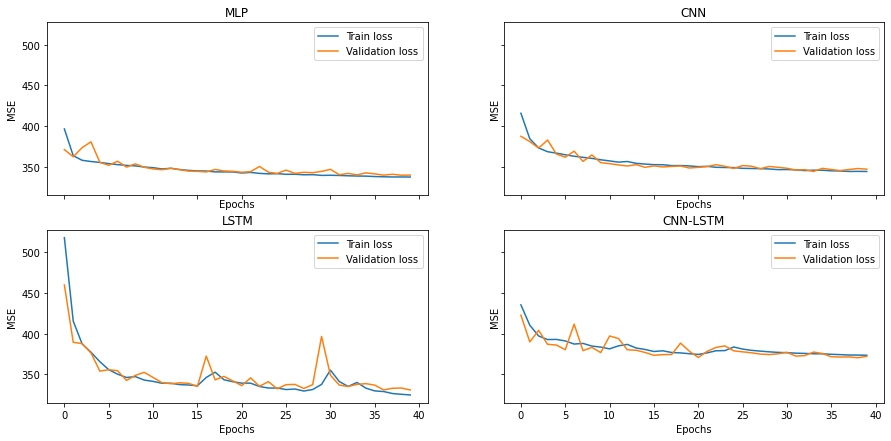

In [ ]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True,figsize=(15,7))
ax1, ax2 = axes[0]
ax3, ax4 = axes[1]

ax1.plot(mlp_history.history['loss'], label='Train loss')
ax1.plot(mlp_history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('MLP')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE')

ax2.plot(cnn_history.history['loss'], label='Train loss')
ax2.plot(cnn_history.history['val_loss'], label='Validation loss')
ax2.legend(loc='best')
ax2.set_title('CNN')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MSE')

ax3.plot(lstm_history.history['loss'], label='Train loss')
ax3.plot(lstm_history.history['val_loss'], label='Validation loss')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('MSE')

ax4.plot(cnn_lstm_history.history['loss'], label='Train loss')
ax4.plot(cnn_lstm_history.history['val_loss'], label='Validation loss')
ax4.legend(loc='best')
ax4.set_title('CNN-LSTM')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('MSE')

plt.show()

### **MLP on train and validation**

In [ ]:
mlp_train_pred = model_mlp.predict(X_train.values)
mlp_valid_pred = model_mlp.predict(X_valid.values)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, mlp_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, mlp_valid_pred)))

2099/2099 [==============================] - 3s 1ms/step
Train rmse: 18.303345596799797
Validation rmse: 18.433527533669864


### **CNN on train and validation**

In [ ]:
cnn_train_pred = model_cnn.predict(X_train_series)
cnn_valid_pred = model_cnn.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_valid_pred)))

2099/2099 [==============================] - 2s 1ms/step
Train rmse: 18.53092562848041
Validation rmse: 18.628522311439262


### **LSTM on train and validation**

In [ ]:
lstm_train_pred = model_lstm.predict(X_train_series)
lstm_valid_pred = model_cnn.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lstm_valid_pred)))

2099/2099 [==============================] - 2s 1ms/step
Train rmse: 18.01257125495788
Validation rmse: 18.628522311439262


### **CNN-LSTM on train and validation**

In [ ]:
cnn_lstm_train_pred = model_cnn_lstm.predict(X_train_series_sub)
cnn_lstm_valid_pred = model_cnn_lstm.predict(X_valid_series_sub)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_lstm_valid_pred)))

2099/2099 [==============================] - 4s 2ms/step
Train rmse: 19.306981591207364
Validation rmse: 19.28944731524664


**There are many other models to forecast time series, such as weighted moving average models or autoregressive integrated moving average (ARIMA) models. Some of them require you to first remove the trend and seasonality. For example, if you are studying the number of active users on your website, and it is growing by 10% every month, you would have to remove this trend from the time series. Once the model is trained and starts making predictions, you would have to add the trend back to get the final predictions. Similarly, if you are trying to predict the amount of sunscreen lotion sold every month, you will probably observe strong seasonality: since it sells well every summer, a similar pattern will be repeated every year. You would have to remove this seasonality from the time series, for example by computing the difference between the value at each time step and the value one year earlier (this technique is called differencing). Again, after the model is trained and makes predictions, you would have to add the seasonal pattern back to get the final predictions.**

### **BY USING ARIMA MODEL**

In [ ]:
from pylab import rcParams
import statsmodels.api as sm
import warnings
import itertools
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
df = pd.read_csv('/content/train.csv')

In [ ]:
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [ ]:
df['date'] =  pd.to_datetime(df['date'])

**Set Date as Index**

In [ ]:
df = df.set_index('date')

In [ ]:
df.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


In [ ]:
df.sales.sum()

47704512

In [ ]:
salesbymonth = df.sales.resample('M').sum()

In [ ]:
salesbymonth.head()

date
2013-01-31    454904
2013-02-28    459417
2013-03-31    617382
2013-04-30    682274
2013-05-31    763242
Freq: M, Name: sales, dtype: int64

In [ ]:
split = "2017-01-01"

In [ ]:
salesbymonth_train= salesbymonth[:split]

In [ ]:
salesbymonth_train.head()

date
2013-01-31    454904
2013-02-28    459417
2013-03-31    617382
2013-04-30    682274
2013-05-31    763242
Freq: M, Name: sales, dtype: int64

In [ ]:
salesbymonth_test= salesbymonth[split:]

In [ ]:
salesbymonth_test_final=salesbymonth_test.copy() # This file is used to compare all the predections

In [ ]:
salesbymonth_test_final = pd.DataFrame(salesbymonth_test_final)

In [ ]:
salesbymonth_test_final.head()

,sales
date,
2017-01-31,617306
2017-02-28,621369
2017-03-31,822667
2017-04-30,938862
2017-05-31,1020686


In [ ]:
salesbymonth_test_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12 entries, 2017-01-31 to 2017-12-31
Freq: M
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   sales   12 non-null     int64
dtypes: int64(1)
memory usage: 192.0 bytes


In [ ]:
salesbymonth.sample(5)

date
2016-04-30     901950
2016-06-30    1022664
2013-03-31     617382
2017-01-31     617306
2017-03-31     822667
Name: sales, dtype: int64

### **Sales by Day**

In [ ]:
salesbyday = df.sales.resample('D').sum()

In [ ]:
salesbyday_train= salesbyday[:split]

In [ ]:
salesbyday_test= salesbyday[split:]

In [ ]:
salesbyday_test_final=salesbyday_test.copy() # This file is used to compare all the daily forecasts

In [ ]:
salesbyday_test_final = pd.DataFrame(salesbyday_test_final)

In [ ]:
salesbyday_test_final.head()

,sales
date,
2017-01-01,23709
2017-01-02,15772
2017-01-03,18650
2017-01-04,18510
2017-01-05,19895


## **Seasonal ARIMA by Month**

In [ ]:
rcParams['figure.figsize'] = 15,7

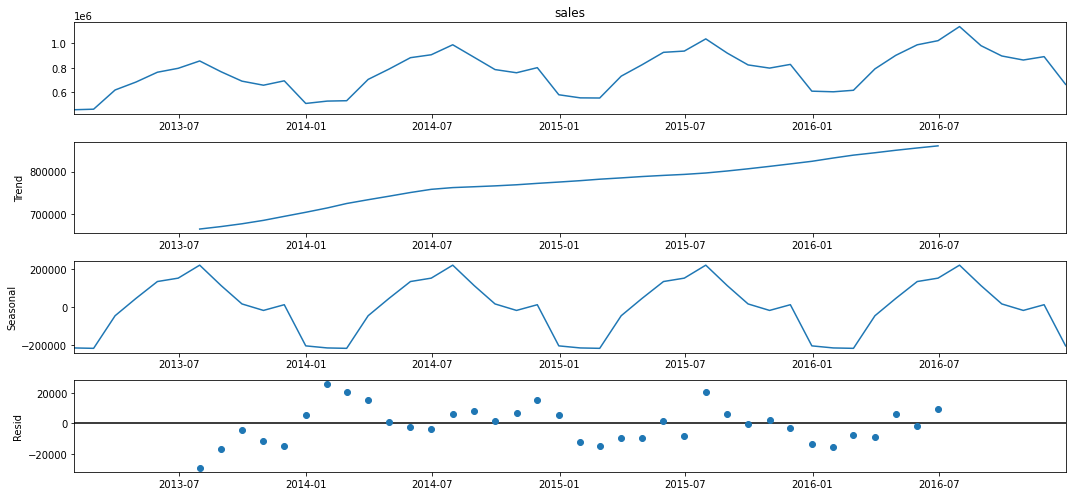

In [ ]:
decomposition = sm.tsa.seasonal_decompose(salesbymonth_train, model='additive')
fig = decomposition.plot()
plt.show()

In [ ]:
p = d = q = range(0, 2)

In [ ]:
pdqa = list(itertools.product(p, d, q))

In [ ]:
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
for param in pdqa:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(salesbymonth_train, order=param, seasonal_order=param_seasonal,
                                            enforce_stationarity=False,enforce_invertibility=False)                                
            results = modl.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue


In [ ]:
SARIMAMonth = sm.tsa.statespace.SARIMAX(salesbymonth, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12) ,
                                        enforce_stationarity=False,enforce_invertibility=False)

In [ ]:
SARIMA_results_month = SARIMAMonth.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [ ]:
print(SARIMA_results_month.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0119   3.96e-26  -2.56e+25      0.000      -1.012      -1.012
ma.L1          0.8282   4.87e-26    1.7e+25      0.000       0.828       0.828
ar.S.L12      -0.1692   3.96e-27  -4.27e+25      0.000      -0.169      -0.169
ma.S.L12    1.212e+14   5.17e-33   2.34e+46      0.000    1.21e+14    1.21e+14
sigma2      2.836e-13    3.3e-10      0.001      0.999   -6.47e-10    6.48e-10


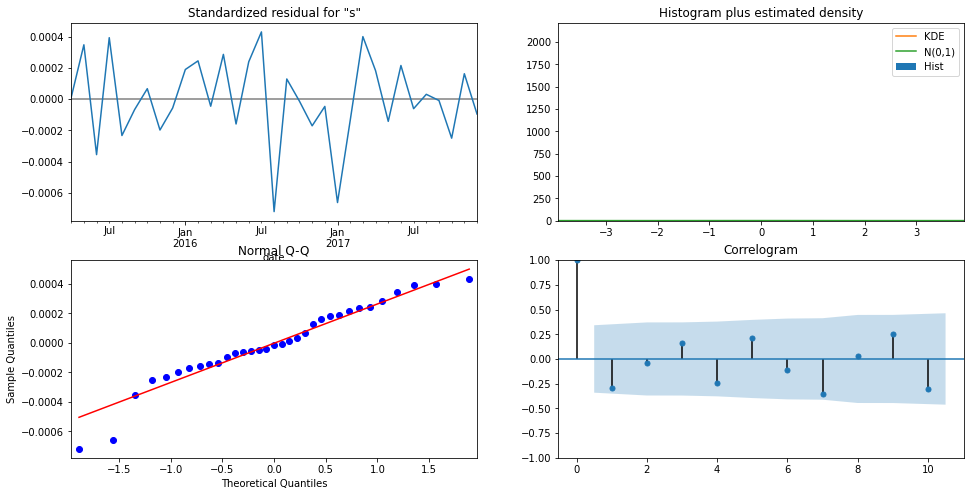

In [ ]:
SARIMA_results_month.plot_diagnostics(figsize=(16, 8))
plt.show()

In [ ]:
#SARIMA_predict_month_1 = SARIMA_results_month.predict(start=1461,end=1825) # this is from 1 Jan 2017 to 31 Dec 2017

In [ ]:
#SARIMA_predict_month_1 = SARIMA_month_model.predict(start=48,end=60,rder=(1, 1, 1), seasonal_order=(1, 1, 1, 12) ,enforce_stationarity=False,enforce_invertibility=False) # this is from Jan 2017 to  Dec 2017

SARIMA_predict_month_1 = SARIMA_results_month.predict(start=48,end=60) #,order=(1, 1, 1), seasonal_order=(1, 1, 1, 12) ,enforce_stationarity=False,enforce_invertibility=False) # this is from Jan 2017 to  Dec 2017
print(SARIMA_predict_month_1)

2017-01-31    6.599549e+05
2017-02-28    6.301506e+05
2017-03-31    7.968561e+05
2017-04-30    9.271019e+05
2017-05-31    1.029838e+06
2017-06-30    1.050734e+06
2017-07-31    1.175322e+06
2017-08-31    1.024404e+06
2017-09-30    9.358115e+05
2017-10-31    9.072488e+05
2017-11-30    9.183400e+05
2017-12-31    7.012990e+05
2018-01-31    6.579801e+05
Freq: M, Name: predicted_mean, dtype: float64


In [ ]:
salesbymonth_test_final['SeasonalARIMA'] = SARIMA_predict_month_1

In [ ]:
salesbymonth_test_final.head()

,sales,SeasonalARIMA
date,,
2017-01-31,617306,6.599549e+05
2017-02-28,621369,6.301506e+05
2017-03-31,822667,7.968561e+05
2017-04-30,938862,9.271019e+05
2017-05-31,1020686,1.029838e+06


In [ ]:
RMSE_Month_Seasonal_ARIMA  = np.mean(np.sqrt((salesbymonth_test_final['SeasonalARIMA'] - salesbymonth_test_final['sales']) ** 2)) 
print(RMSE_Month_Seasonal_ARIMA)

12602.889539986287


## **AR by Month**

In [ ]:
model_ar_month = AR (salesbymonth_train)

In [ ]:
model_ar_month_fit = model_ar_month.fit()

In [ ]:
predictions_month_1 = model_ar_month_fit.predict(start=48,end=59)

In [ ]:
AR_month_predictions=pd.DataFrame(predictions_month_1, columns =['AR'])

In [ ]:
AR_month_predictions.head()

,AR
2017-01-31,605735.098158
2017-02-28,665165.171144
2017-03-31,863257.355139
2017-04-30,849575.834745
2017-05-31,946033.750945


In [ ]:
salesbymonth_test.head(3)

date
2017-01-31    617306
2017-02-28    621369
2017-03-31    822667
Freq: M, Name: sales, dtype: int64

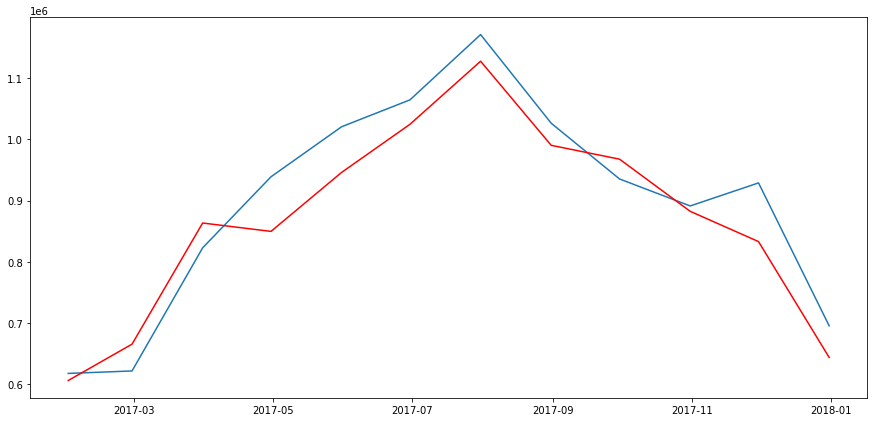

In [ ]:
plt.plot(salesbymonth_test)
plt.plot(AR_month_predictions['AR'], color = 'red')

In [ ]:
salesbymonth_test_final['sales']

date
2017-01-31     617306
2017-02-28     621369
2017-03-31     822667
2017-04-30     938862
2017-05-31    1020686
2017-06-30    1064624
2017-07-31    1171393
2017-08-31    1026403
2017-09-30     935263
2017-10-31     891160
2017-11-30     928837
2017-12-31     695170
Freq: M, Name: sales, dtype: int64

In [ ]:
salesbymonth_test_final['AR'] = AR_month_predictions['AR']

In [ ]:
RMSE_Month_AR  = np.mean(np.sqrt((salesbymonth_test_final['AR'] - salesbymonth_test_final['sales']) ** 2)) 
print(RMSE_Month_AR)

47361.24511447805


In [ ]:
salesbymonth_test_final['AR_error'] = salesbymonth_test_final['AR'] - salesbymonth_test_final['sales']
salesbymonth_test_final['AR_error_percent'] = salesbymonth_test_final['AR_error'] / salesbymonth_test_final['sales']

In [ ]:
salesbymonth_test_final.sample(10)

,sales,SeasonalARIMA,AR,AR_error,AR_error_percent
date,,,,,
2017-07-31,1171393,1.175322e+06,1.127842e+06,-43550.562522,-0.037178
2017-06-30,1064624,1.050734e+06,1.024679e+06,-39944.881314,-0.037520
2017-09-30,935263,9.358115e+05,9.676412e+05,32378.152980,0.034619
2017-11-30,928837,9.183400e+05,8.328766e+05,-95960.364305,-0.103312
2017-02-28,621369,6.301506e+05,6.651652e+05,43796.171144,0.070483
2017-05-31,1020686,1.029838e+06,9.460338e+05,-74652.249055,-0.073139
2017-12-31,695170,7.012990e+05,6.434593e+05,-51710.741026,-0.074386
2017-08-31,1026403,1.024404e+06,9.902866e+05,-36116.431426,-0.035187
2017-03-31,822667,7.968561e+05,8.632574e+05,40590.355139,0.049340


In [ ]:
salesbymonth_test_final.sum()

sales               1.073374e+07
SeasonalARIMA       1.075706e+07
AR                  1.039893e+07
AR_error           -3.348056e+05
AR_error_percent   -3.299755e-01
dtype: float64

In [ ]:
salesbymonth_test_final.head()

,sales,SeasonalARIMA,AR,AR_error,AR_error_percent
date,,,,,
2017-01-31,617306,6.599549e+05,605735.098158,-11570.901842,-0.018744
2017-02-28,621369,6.301506e+05,665165.171144,43796.171144,0.070483
2017-03-31,822667,7.968561e+05,863257.355139,40590.355139,0.049340
2017-04-30,938862,9.271019e+05,849575.834745,-89286.165255,-0.095100
2017-05-31,1020686,1.029838e+06,946033.750945,-74652.249055,-0.073139


In [ ]:
salesbymonth_train.head()

date
2013-01-31    454904
2013-02-28    459417
2013-03-31    617382
2013-04-30    682274
2013-05-31    763242
Freq: M, Name: sales, dtype: int64

## **SARIMA by day**

In [ ]:
decomposition_day = sm.tsa.seasonal_decompose(salesbyday_train, model='additive')

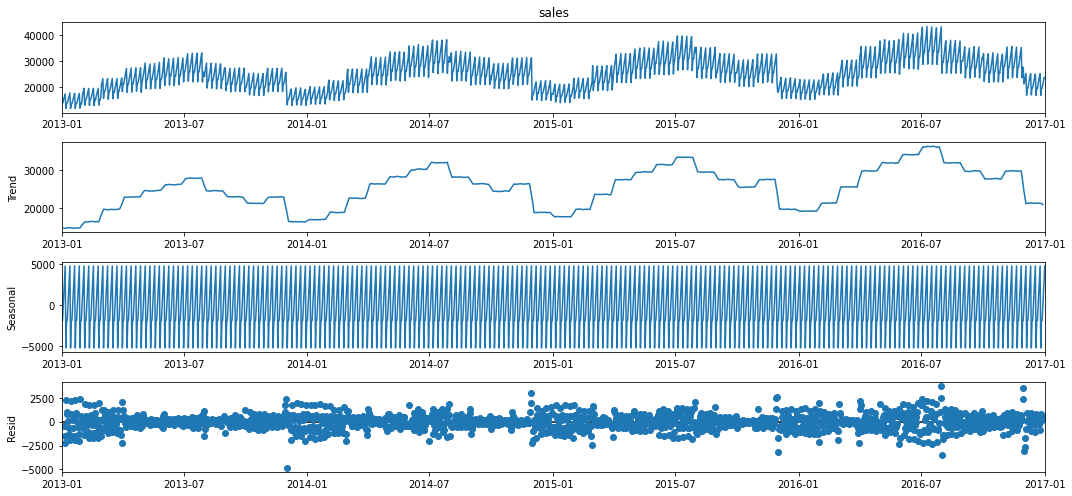

In [ ]:
fig = decomposition_day.plot()
plt.show()

In [ ]:
p = d = q = range(0, 2)

In [ ]:
pdqb = list(itertools.product(p, d, q))
seasonal_pdq_day = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
for param in pdqb:
    for param_seasonal_day in seasonal_pdq_day:
        try:
            mod = sm.tsa.statespace.SARIMAX(salesbyday_train, order=param, seasonal_order=param_seasonal,
                                            enforce_stationarity=False,enforce_invertibility=False)                                
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal_day, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:28452.9928501566
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:28452.9928501566
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:28452.9928501566
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:28452.9928501566
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:28452.9928501566
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:28452.9928501566
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:28452.9928501566
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:28452.9928501566
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:28182.714177344686
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:28182.714177344686
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:28182.714177344686
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:28182.714177344686
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:28182.714177344686
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:28182.714177344686
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:28182.714177344686
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:28182.714177344686
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:28357.725616254735
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:28357.725616254735
ARIMA(0,

In [ ]:
SARIMADay = sm.tsa.statespace.SARIMAX(salesbyday, order=(0, 1, 1), seasonal_order=(0, 1, 1, 12) ,
                                      enforce_stationarity=False,enforce_invertibility=False)

In [ ]:
SARIMA_results_day = SARIMADay.fit()

In [ ]:
print(SARIMA_results_day.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8673      0.028    -31.004      0.000      -0.922      -0.812
ma.S.L12      -0.9760      0.020    -48.536      0.000      -1.015      -0.937
sigma2      3.954e+07   3.08e-11   1.28e+18      0.000    3.95e+07    3.95e+07


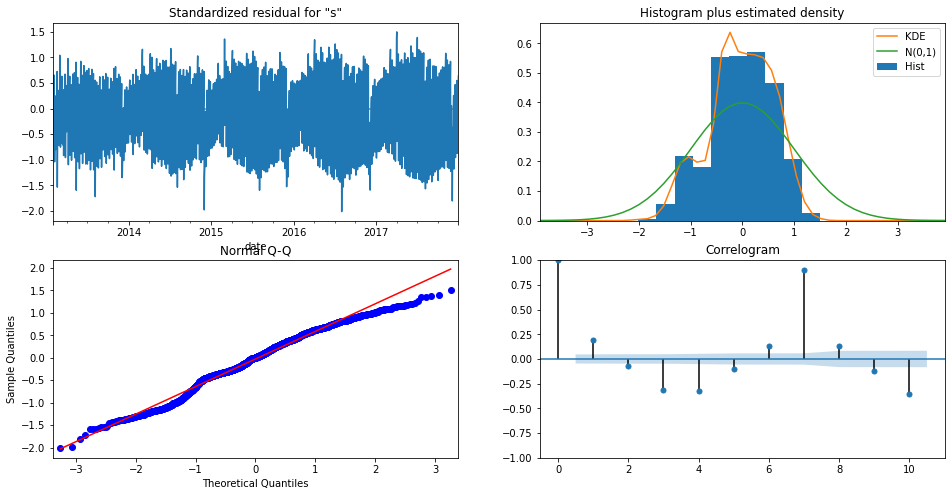

In [ ]:
SARIMA_results_day.plot_diagnostics(figsize=(16, 8))
plt.show()

In [ ]:
SARIMA_predict_day_1 = SARIMA_results_day.predict(start=1461,end=1825) # this is from 1 Jan 2017 to 31 Dec 2017
print(SARIMA_predict_day_1)


date
2017-01-01    21416.346399
2017-01-02    21858.568527
2017-01-03    20997.332075
2017-01-04    20962.677517
2017-01-05    20393.429809
                  ...     
2017-12-27    22150.027000
2017-12-28    21910.901880
2017-12-29    21957.617034
2017-12-30    22120.350056
2017-12-31    22433.232554
Freq: D, Name: predicted_mean, Length: 365, dtype: float64


In [ ]:
salesbyday_test_final['SeasonalARIMA'] = SARIMA_predict_day_1

In [ ]:
RMSE_Day_SeasonalARIMA  = np.mean(np.sqrt((salesbyday_test_final['SeasonalARIMA'] - salesbyday_test_final['sales']) ** 2)) 
print(RMSE_Day_SeasonalARIMA)

3464.7707588968146


## **ARIMA BY Month**

In [ ]:
model_arima_month = ARIMA(salesbymonth_train, order = (7,1,0))

In [ ]:
salesbymonth_train.tail(12)

date
2016-01-31     602439
2016-02-29     614957
2016-03-31     790881
2016-04-30     901950
2016-05-31     988730
2016-06-30    1022664
2016-07-31    1138718
2016-08-31     981494
2016-09-30     896831
2016-10-31     863637
2016-11-30     891448
2016-12-31     663411
Freq: M, Name: sales, dtype: int64

In [ ]:
model_arima_month_fit = model_arima_month.fit()

In [ ]:
arima_predictions_month = model_arima_month_fit.forecast(steps=12)[0]

In [ ]:
print(arima_predictions_month)

[ 694690.22525091  770673.7165264   906891.83294754  894157.77009681
 1015702.93489995 1043821.95711722 1122819.65097804 1023690.45285968
  983659.43957193  884587.42497984  897863.74841756  811036.92734427]


In [ ]:
ARIMA_month_predictions=pd.DataFrame(arima_predictions_month, columns =['ARIMA'])

In [ ]:
ARIMA_month_predictions['ARIMA']

0     6.946902e+05
1     7.706737e+05
2     9.068918e+05
3     8.941578e+05
4     1.015703e+06
5     1.043822e+06
6     1.122820e+06
7     1.023690e+06
8     9.836594e+05
9     8.845874e+05
10    8.978637e+05
11    8.110369e+05
Name: ARIMA, dtype: float64

In [ ]:
salesbymonth_test_final =salesbymonth_test_final.reset_index()

In [ ]:
salesbymonth_test_final.head()

,date,sales,SeasonalARIMA,AR,AR_error,AR_error_percent
0,2017-01-31,617306,6.599549e+05,605735.098158,-11570.901842,-0.018744
1,2017-02-28,621369,6.301506e+05,665165.171144,43796.171144,0.070483
2,2017-03-31,822667,7.968561e+05,863257.355139,40590.355139,0.049340
3,2017-04-30,938862,9.271019e+05,849575.834745,-89286.165255,-0.095100
4,2017-05-31,1020686,1.029838e+06,946033.750945,-74652.249055,-0.073139


In [ ]:
salesbymonth_test_final['ARIMA'] =ARIMA_month_predictions['ARIMA']

In [ ]:
salesbymonth_test_final.tail(14)

,date,sales,SeasonalARIMA,AR,AR_error,AR_error_percent,ARIMA
0,2017-01-31,617306,6.599549e+05,6.057351e+05,-11570.901842,-0.018744,6.946902e+05
1,2017-02-28,621369,6.301506e+05,6.651652e+05,43796.171144,0.070483,7.706737e+05
2,2017-03-31,822667,7.968561e+05,8.632574e+05,40590.355139,0.049340,9.068918e+05
3,2017-04-30,938862,9.271019e+05,8.495758e+05,-89286.165255,-0.095100,8.941578e+05
4,2017-05-31,1020686,1.029838e+06,9.460338e+05,-74652.249055,-0.073139,1.015703e+06
5,2017-06-30,1064624,1.050734e+06,1.024679e+06,-39944.881314,-0.037520,1.043822e+06
6,2017-07-31,1171393,1.175322e+06,1.127842e+06,-43550.562522,-0.037178,1.122820e+06
7,2017-08-31,1026403,1.024404e+06,9.902866e+05,-36116.431426,-0.035187,1.023690e+06
8,2017-09-30,935263,9.358115e+05,9.676412e+05,32378.152980,0.034619,9.836594e+05
9,2017-10-31,891160,9.072488e+05,8.823820e+05,-8777.965365,-0.009850,8.845874e+05


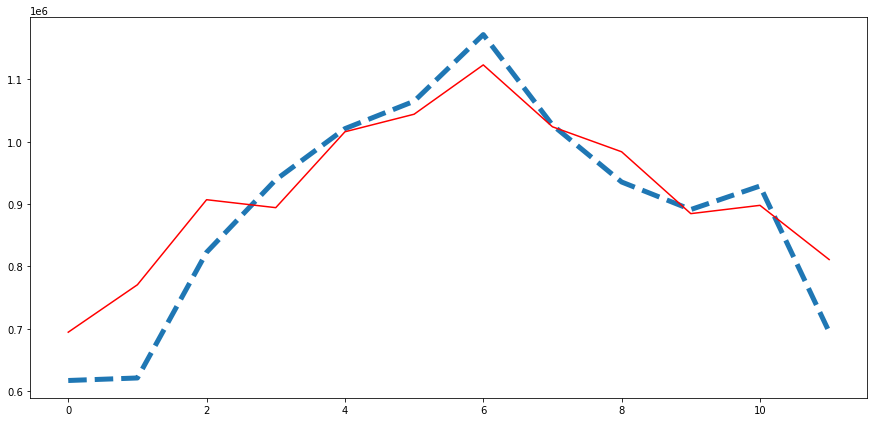

In [ ]:
plt.plot(salesbymonth_test_final['sales'],linestyle='dashed',linewidth=5)
plt.plot(salesbymonth_test_final['ARIMA'], color = 'red' )

In [ ]:
RMSE_Month_ARIMA  = np.mean(np.sqrt((salesbymonth_test_final['ARIMA'] - salesbymonth_test_final['sales']) ** 2)) 
print(RMSE_Month_ARIMA)

52874.850190996825


In [ ]:
p=d=q =range(0,8)

In [ ]:
pdqmontha = list(itertools.product(p,d,q))

In [ ]:
for param in pdqmontha:
    try:
        model_arima_month = ARIMA(salesbymonth_train, order = pdqmontha)
        model_arima_month_fit = model_arima_month.fit()
        print(param,model_arima_month_fit.aic)
    except:
        continue

## **ARIMA per day - as per above**

In [ ]:
model_arima_day = ARIMA(salesbyday_train, order = (2,1,0))

In [ ]:
model_arima_day_fit = model_arima_day.fit()

In [ ]:
arima_predictions_day = model_arima_day_fit.forecast(steps=365)[0]

In [ ]:
ARIMA_day_predictions=pd.DataFrame(arima_predictions_day, columns =['ARIMA'])

In [ ]:
ARIMA_day_predictions['ARIMA']

0      23557.476059
1      23636.106929
2      23636.169230
3      23636.323464
4      23646.599726
           ...     
360    26085.873158
361    26092.726682
362    26099.580205
363    26106.433728
364    26113.287252
Name: ARIMA, Length: 365, dtype: float64

In [ ]:
salesbyday_test_final =salesbyday_test_final.reset_index()

In [ ]:
salesbyday_test_final['ARIMA'] = ARIMA_day_predictions['ARIMA']

In [ ]:
salesbyday_test_final.head()

,date,sales,SeasonalARIMA,ARIMA
0,2017-01-01,23709,21416.346399,23557.476059
1,2017-01-02,15772,21858.568527,23636.106929
2,2017-01-03,18650,20997.332075,23636.169230
3,2017-01-04,18510,20962.677517,23636.323464
4,2017-01-05,19895,20393.429809,23646.599726


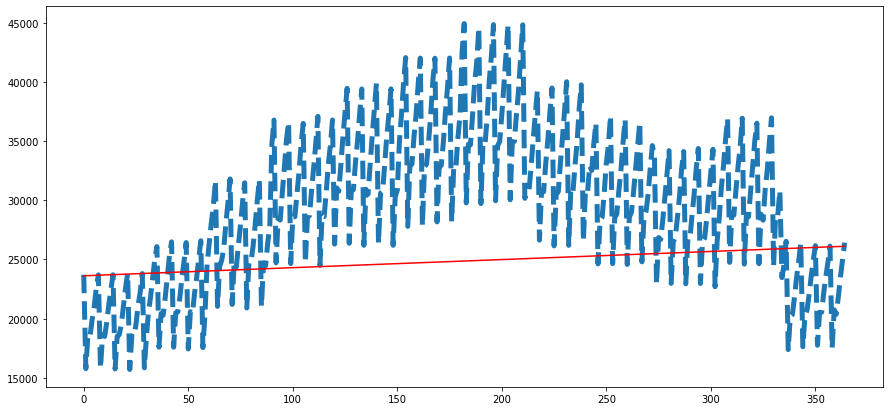

In [ ]:
plt.plot(salesbyday_test_final['sales'],linestyle='dashed',linewidth=5)
plt.plot(salesbyday_test_final['ARIMA'], color = 'red' )

In [ ]:
p=d=q =range(0,5)

In [ ]:
pdqday = list(itertools.product(p,d,q))

In [ ]:
warnings.filterwarnings('ignore')
for param in pdqday:
    try:
        model_arima_month = ARIMA(salesbymonth_train, order = param)
        model_arima_month_fit = model_arima_month.fit()
        print(param,model_arima_month_fit.aic)
    except:
        continue

(0, 0, 0) 1292.3700483098567
(0, 0, 1) 1266.3682906155727
(0, 0, 2) 1240.9284836162374
(0, 0, 3) 1242.6052268002504
(0, 0, 4) 1230.9306048189637
(0, 1, 0) 1222.917698590096
(0, 1, 1) 1223.6608293672457
(0, 1, 2) 1224.0635142993015
(0, 1, 3) 1216.1602850069182
(0, 1, 4) 1215.9703150465361
(0, 2, 0) 1217.4472892188855
(0, 2, 1) nan
(0, 2, 2) 1203.3519424580638
(0, 2, 3) 1203.5165898655293
(0, 2, 4) 1207.9788554252164
(1, 0, 0) 1247.7641694479717
(1, 0, 1) 1247.0764244197499
(1, 0, 2) 1244.1019354162486
(1, 0, 3) 1246.207391013139
(1, 0, 4) 1228.680906493682
(1, 1, 0) 1223.1877471761125
(1, 2, 0) 1207.9432158880086
(1, 2, 1) 1197.8439985229516
(1, 2, 3) 1177.7358858858963
(1, 2, 4) 1179.7083616423283
(2, 0, 0) 1244.3757831942771
(2, 0, 1) 1240.4602630678119
(2, 0, 2) 1236.7740497508366
(2, 0, 3) 1231.9044391624093
(2, 0, 4) 1230.117238138875
(2, 1, 0) 1224.2863588382677
(2, 2, 0) 1209.7262978232545
(2, 2, 1) 1221.1318114651174
(3, 0, 0) 1240.4983409958836
(3, 0, 1) 1241.0107159536183
(3, 

In [ ]:
ARIMA_day_predictions.tail()

,ARIMA
360,26085.873158
361,26092.726682
362,26099.580205
363,26106.433728
364,26113.287252


In [ ]:
RMSE_Day_ARIMA  = np.mean(np.sqrt((salesbyday_test_final['ARIMA'] - salesbyday_test_final['sales']) ** 2))
print(RMSE_Day_ARIMA)

6335.6894359029575


In [ ]:
salesbyday_test_final.shape

(365, 4)

## **AR by Day**

In [ ]:
model_ar_day = AR (salesbyday_train)

In [ ]:
model_ar_day_fit = model_ar_day.fit()

In [ ]:
predictions_day_1 = model_ar_day_fit.predict(start=1461,end=1825)

In [ ]:
predictions_day_1.head()

2017-01-01    24876.025870
2017-01-02    15729.296835
2017-01-03    18572.547994
2017-01-04    18686.438272
2017-01-05    20418.203622
Freq: D, dtype: float64

In [ ]:
AR_day_predictions=pd.DataFrame(predictions_day_1, columns =['AR'])

In [ ]:
AR_day_predictions.shape

(365, 1)

In [ ]:
AR_day_predictions.head()

,AR
2017-01-01,24876.025870
2017-01-02,15729.296835
2017-01-03,18572.547994
2017-01-04,18686.438272
2017-01-05,20418.203622


In [ ]:
salesbyday_test_final['sales']

0      23709
1      15772
2      18650
3      18510
4      19895
       ...  
360    20378
361    21885
362    23535
363    24988
364    26420
Name: sales, Length: 365, dtype: int64

In [ ]:
salesbyday_test_final.head()

,date,sales,SeasonalARIMA,ARIMA
0,2017-01-01,23709,21416.346399,23557.476059
1,2017-01-02,15772,21858.568527,23636.106929
2,2017-01-03,18650,20997.332075,23636.169230
3,2017-01-04,18510,20962.677517,23636.323464
4,2017-01-05,19895,20393.429809,23646.599726


In [ ]:
AR_day_predictions.shape

(365, 1)

In [ ]:
salesbyday_test_final['AR'] = AR_day_predictions['AR']

In [ ]:
salesbyday_test_final.head()

,date,sales,SeasonalARIMA,ARIMA,AR
0,2017-01-01,23709,21416.346399,23557.476059,NaN
1,2017-01-02,15772,21858.568527,23636.106929,NaN
2,2017-01-03,18650,20997.332075,23636.169230,NaN
3,2017-01-04,18510,20962.677517,23636.323464,NaN
4,2017-01-05,19895,20393.429809,23646.599726,NaN


In [ ]:
RMSE_Day_AR  = np.mean(np.sqrt((salesbyday_test_final['AR'] - salesbyday_test_final['sales']) ** 2))
print(RMSE_Day_AR)

nan


In [ ]:
salesbyday_test_final['AR_error'] = salesbyday_test_final['AR'] - salesbyday_test_final['sales']

In [ ]:
salesbyday_test_final['AR_error_percent'] = salesbyday_test_final['AR_error'] / salesbyday_test_final['sales']

In [ ]:
salesbyday_test_final.head(12)

,date,sales,SeasonalARIMA,ARIMA,AR,AR_error,AR_error_percent
0,2017-01-01,23709,21416.346399,23557.476059,NaN,NaN,NaN
1,2017-01-02,15772,21858.568527,23636.106929,NaN,NaN,NaN
2,2017-01-03,18650,20997.332075,23636.169230,NaN,NaN,NaN
3,2017-01-04,18510,20962.677517,23636.323464,NaN,NaN,NaN
4,2017-01-05,19895,20393.429809,23646.599726,NaN,NaN,NaN
5,2017-01-06,20994,20190.150455,23653.019132,NaN,NaN,NaN
6,2017-01-07,22591,20187.785835,23659.595085,NaN,NaN,NaN
7,2017-01-08,23700,20556.179068,23666.610167,NaN,NaN,NaN
8,2017-01-09,15797,21098.500457,23673.438203,NaN,NaN,NaN
9,2017-01-10,18608,20396.222082,23680.280523,NaN,NaN,NaN


In [ ]:
salesbyday_test_final.sum()

sales               1.073374e+07
SeasonalARIMA       1.073870e+07
ARIMA               9.076021e+06
AR                  0.000000e+00
AR_error            0.000000e+00
AR_error_percent    0.000000e+00
dtype: float64

In [ ]:
salesbymonth_test_final.sum()

sales               1.073374e+07
SeasonalARIMA       1.075706e+07
AR                  1.039893e+07
AR_error           -3.348056e+05
AR_error_percent   -3.299755e-01
ARIMA               1.104960e+07
dtype: float64

In [ ]:
salesbyday_test_final.reset_index()

,index,date,sales,SeasonalARIMA,ARIMA,AR,AR_error,AR_error_percent
0,0,2017-01-01,23709,21416.346399,23557.476059,NaN,NaN,NaN
1,1,2017-01-02,15772,21858.568527,23636.106929,NaN,NaN,NaN
2,2,2017-01-03,18650,20997.332075,23636.169230,NaN,NaN,NaN
3,3,2017-01-04,18510,20962.677517,23636.323464,NaN,NaN,NaN
4,4,2017-01-05,19895,20393.429809,23646.599726,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
360,360,2017-12-27,20378,22150.027000,26085.873158,NaN,NaN,NaN
361,361,2017-12-28,21885,21910.901880,26092.726682,NaN,NaN,NaN
362,362,2017-12-29,23535,21957.617034,26099.580205,NaN,NaN,NaN
363,363,2017-12-30,24988,22120.350056,26106.433728,NaN,NaN,NaN


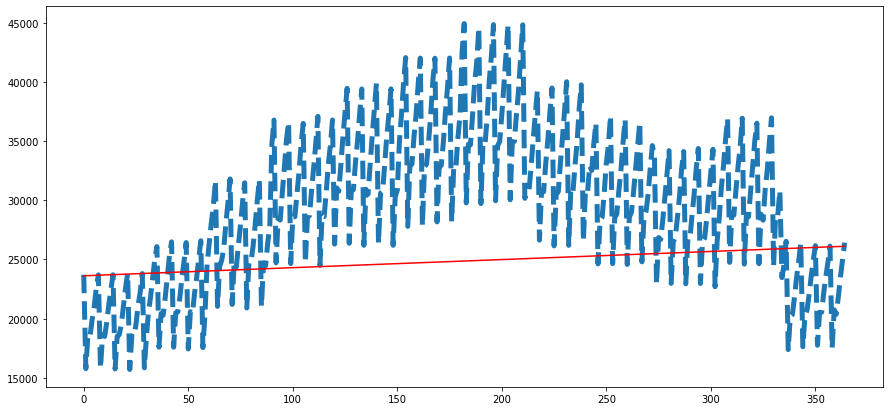

In [ ]:
plt.plot(salesbyday_test_final['sales'],linestyle='dashed',linewidth=5)
plt.plot(salesbyday_test_final['ARIMA'], color = 'red' )

In [ ]:
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import probplot
from pylab import rcParams


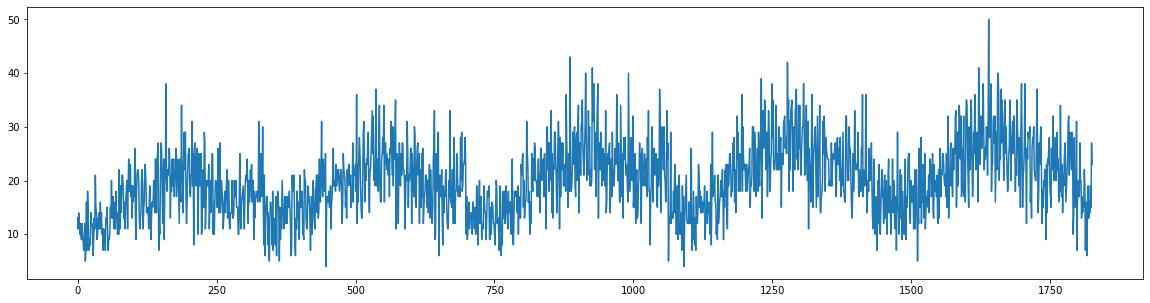

In [ ]:
sales = train[train.store==1][train.item==1].sales
rcParams['figure.figsize'] = 20, 5
plt.plot(sales)

### **Trends, Seasonality and Noise**

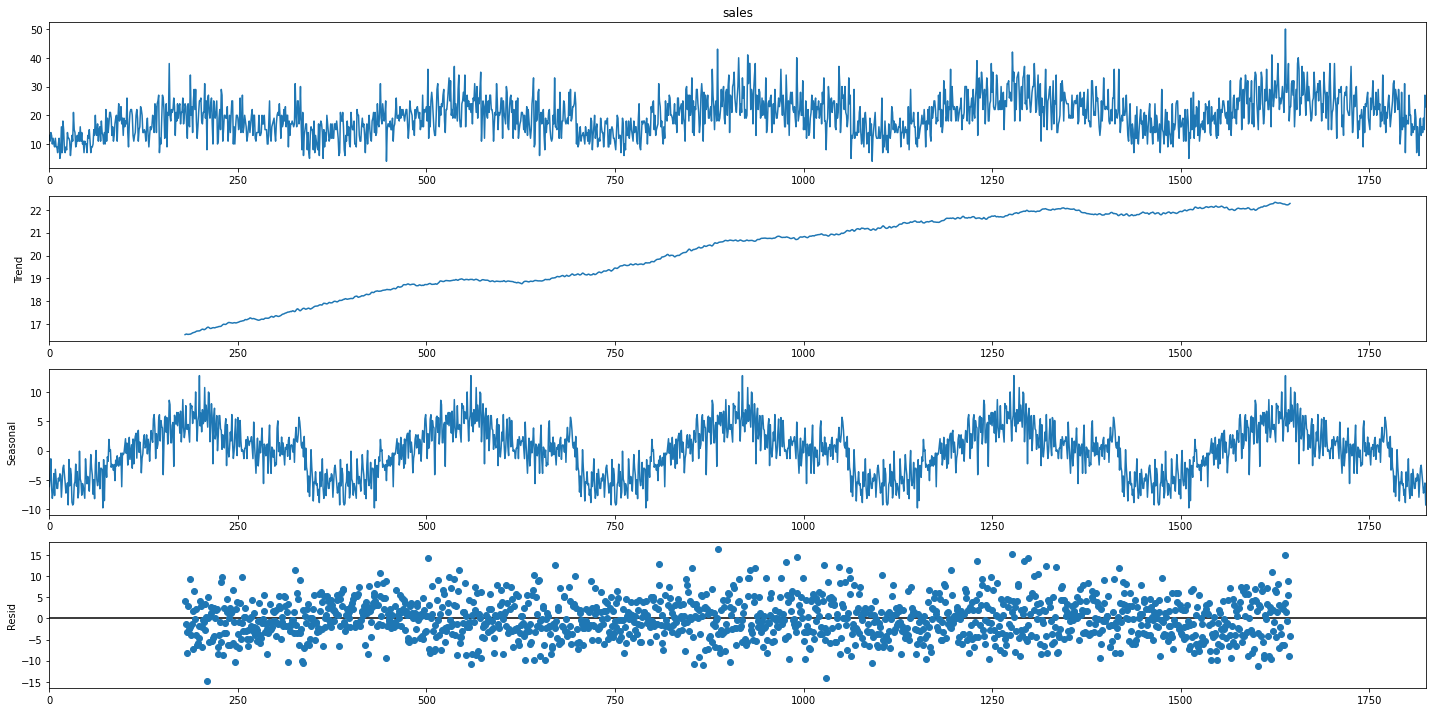

In [ ]:
rcParams['figure.figsize'] = 20, 10
figure = sm.tsa.seasonal_decompose(sales,freq=360).plot() # decompose with 360
figure.show()

### **Stationarity**

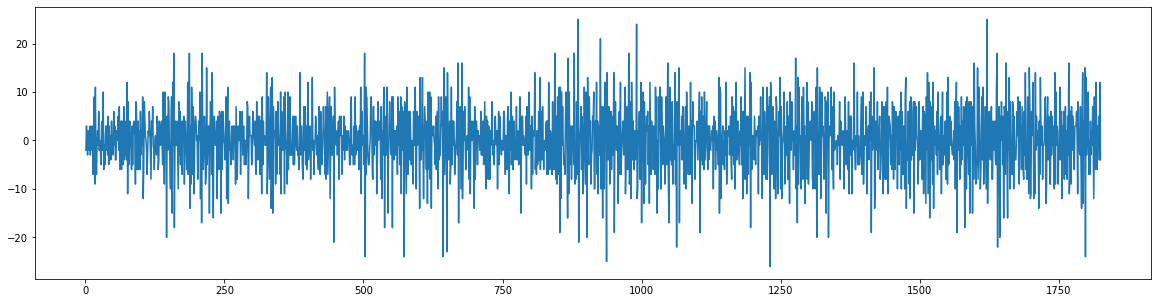

In [ ]:
sales_diff1 = sales.diff(1).iloc[1:]
rcParams['figure.figsize'] = 20, 5
plt.plot(sales_diff1)

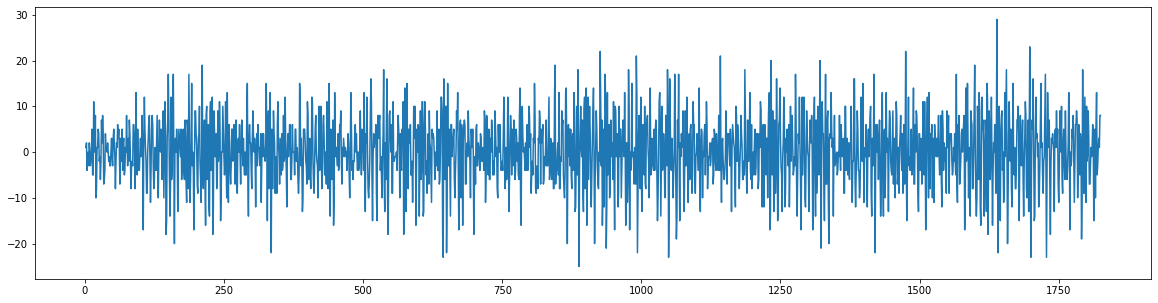

In [ ]:
sales_diff2 = sales.diff(2).iloc[2:]
rcParams['figure.figsize'] = 20, 5
plt.plot(sales_diff2)

### **Autocorrelation**

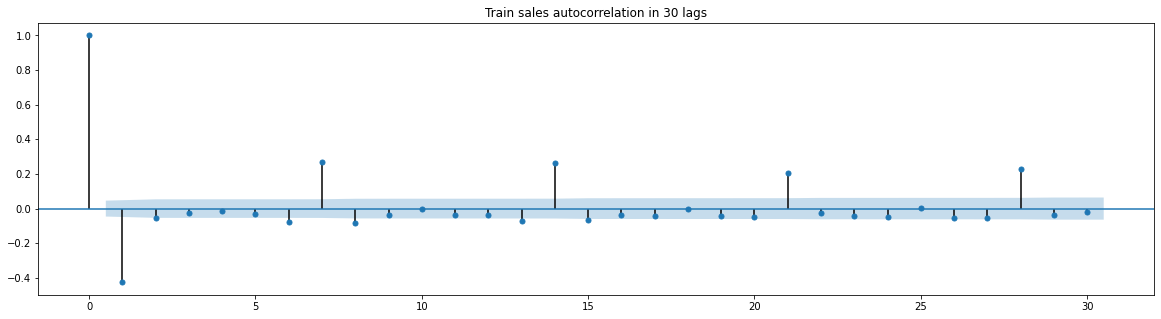

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
rcParams['figure.figsize'] = 20, 5
figure = plot_acf(sales_diff1,lags=30,title='Train sales autocorrelation in 30 lags')
figure.show()

### **Partial Autocorrelation**

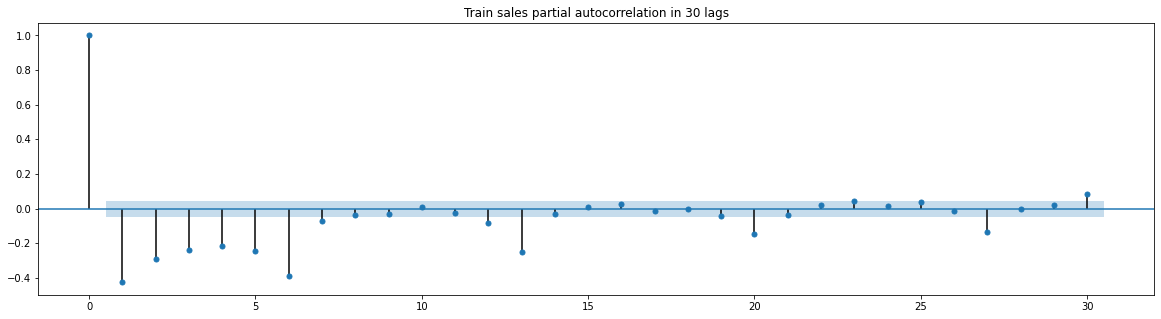

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
rcParams['figure.figsize'] = 20, 5
figure = plot_pacf(sales_diff1,lags=30,title='Train sales partial autocorrelation in 30 lags')
figure.show()


### **Predict by ARIMA**

In [ ]:
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.8)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error
    
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    return best_cfg, best_score

In [ ]:
# p_values = range(6,9)
# d_values = range(0,3)
# q_values = range(0,3)
# best_cfg, best_score = evaluate_models(sales.values, p_values, d_values, q_values)
best_cfg=(7,1,1) # for sales

                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                 1825
Model:                 ARIMA(7, 1, 1)   Log Likelihood               -5572.945
Method:                       css-mle   S.D. of innovations              5.125
Date:                Sun, 13 Nov 2022   AIC                          11165.890
Time:                        16:05:59   BIC                          11220.984
Sample:                             1   HQIC                         11186.213
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0036      0.012      0.299      0.765      -0.020       0.027
ar.L1.D.sales     0.0449      0.031      1.457      0.145      -0.015       0.105
ar.L2.D.sales    -0.0597      0.029     

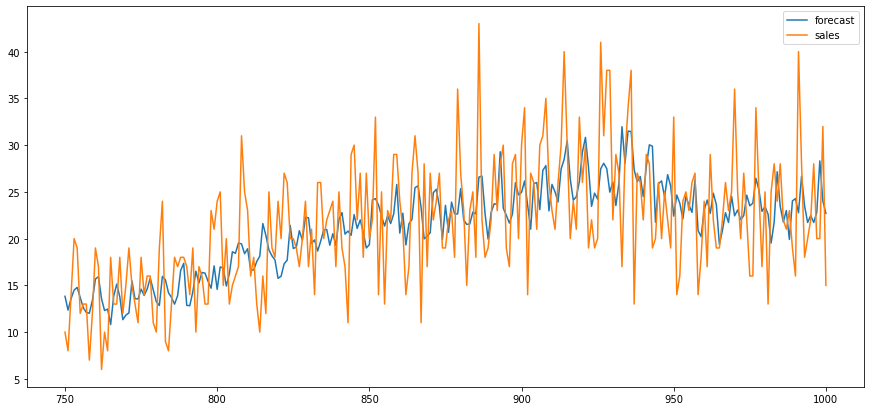

In [ ]:
rcParams['figure.figsize'] = 15, 7
model = ARIMA(sales, order=best_cfg) # 7 from ar, 1 from diff, 1 for ma.
result = model.fit()
print(result.summary())
result.plot_predict(start=750, end=1000)
plt.show()

In [ ]:
rmse = np.sqrt(mean_squared_error(sales.diff().iloc[1:1001].values, result.predict(start=1,end=1000)))
print("The root mean squared error with ARIMA(1,1,0) is {%f}." % rmse)

The root mean squared error with ARIMA(1,1,0) is {4.881746}.


## **CONCLUSION**
By using the given dataset and train the dataset by using different models like MLP, CNN, LSTN, CNN_LSTN could see some approaches to a time series problem, how to develop and the differences between them, this is not meant to have a great performance, as we have calculated the RSME for each one of the that also,

In CNN the

train rmse :18.53092562848041 and

Validation rmse: 18.628522311439262

In LSTM the

Train rmse: 18.01257125495788

Validation rmse: 18.628522311439262

In CNN-LSTM the

Train rmse: 19.306981591207364

Validation rmse: 19.28944731524664


There are many other models to forecast time series, such as weighted moving average models or autoregressive integrated moving average (ARIMA) models. Some of them require you to first remove the trend and seasonality. For example, if you are studying the number of active users on your website, and it is growing by 10% every month, you would have to remove this trend from the time series. Once the model is trained and starts making predictions, you would have to add the trend back to get the final predictions. Similarly, if you are trying to predict the amount of sunscreen lotion sold every month, you will probably observe strong seasonality: since it sells well every summer, a similar pattern will be repeated every year. You would have to remove this seasonality from the time series, for example by computing the difference between the value at each time step and the value one year earlier (this technique is called differencing). Again, after the model is trained and makes predictions, you would have to add the seasonal pattern back to get the final predictions.

By using ARIMA the

The root mean squared error with ARIMA(1,1,0) is {4.881746}.
